<a href="https://colab.research.google.com/github/abdala-Mohamed/ecg_classification/blob/master/graduation_ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##import

In [0]:
import numpy as np
import scipy.io
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import os
from keras import backend as K
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.layers import Dropout
from keras.layers import Conv1D
from keras.layers import Add 
from keras.layers import MaxPooling1D
from keras.layers.core import Lambda
from keras.layers.core import Dense, Activation
from keras.layers.wrappers import TimeDistributed
from keras.models import Model
from keras.layers import Input
from keras.optimizers import Adam

##Download

In [0]:
!wget https://physionet.org/files/challenge-2017/1.0.0/training2017.zip?download
!wget https://physionet.org/files/challenge-2017/1.0.0/training/RECORDS-af?download
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-noisy
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-normal
!wget https://physionet.org/content/challenge-2017/1.0.0/training/RECORDS-other
!unzip /content/training2017.zip?download

##Data_preperation

In [0]:
f = open("/content/RECORDS-af?download", "r")
Records_af = f.read().split("\n")#spilt by '/' and choose the 2nd word to get the name
f = open("/content/RECORDS-noisy", "r")
Records_noisy = f.read().split("\n")
f = open("/content/RECORDS-normal", "r")
Records_normal = f.read().split("\n")
f = open("/content/RECORDS-other", "r")
Records_other = f.read().split("\n")

normal

[-127 -162 -197 ...  -18  -22  -21]


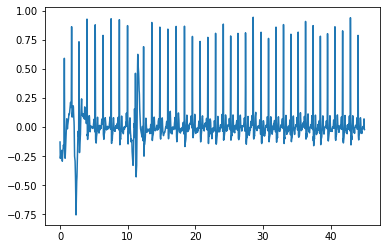

In [13]:
mat = scipy.io.loadmat('/content/training2017/A00001.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)
print(data)

af_rythm

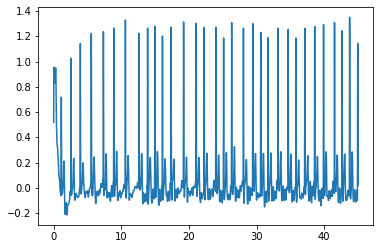

In [6]:
mat = scipy.io.loadmat('/content/training2017/A00004.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)

other

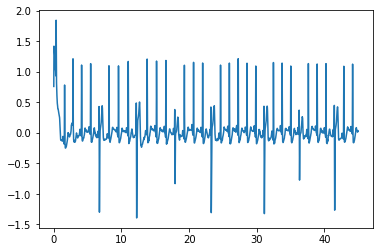

In [7]:
mat = scipy.io.loadmat('/content/training2017/A00077.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)

noise

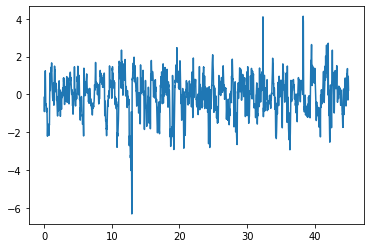

In [8]:
mat = scipy.io.loadmat('/content/training2017/A01246.mat')
data = np.array(mat['val']).squeeze()
plt.plot(np.linspace(0,len(data)/200,num = len(data)),data/1000)

train_set

In [0]:
def look_for_file(file,Records_af,Records_normal,Records_other,Records_noisy):
  for subject in Records_af:
    if (subject.split("/") == False) or (len(subject.split("/"))==1) :
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 1
  for subject in Records_normal:
    if (subject.split("/") == False) or (len(subject.split("/"))==1):
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 2
  for subject in Records_other:
    if (subject.split("/") == False) or (len(subject.split("/"))==1):
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 3
  for subject in Records_noisy:
    if (subject.split("/") == False) or (len(subject.split("/"))==1):
      continue
    cla_ss = subject.split("/")[1]
    if '<' in (cla_ss):
      cla_ss = cla_ss.split("<")[0]
    if file == cla_ss:
      return 4
  print()
  return 0

In [0]:
#Records_af = 1
#Records_normal = 2
#Records_other = 3
#Records_noisy = 4
dir = "/content/training2017"
train_dataset = []
file_order = []
class_dataset = np.zeros((1,8528))
for i in range(0,8528):
  train_dataset.append([])
i = 0
for file in os.listdir( dir ):
  #print(i)
  if file.endswith( ".mat" ):
    mat = scipy.io.loadmat('/content/training2017/'+file)    
    type = look_for_file(file.split(".")[0],Records_af,Records_normal,Records_other,Records_noisy)
    if type == 0:
      print(file)
      print("stop excution")
      break
    class_dataset[0][i] = type
    train_data = np.array(mat['val']).squeeze()
    for j in train_data:
      train_dataset[i].append(j)
    i+=1

##Model

#model written

In [0]:

def _bn_relu(layer, dropout=0, **params):
    layer = BatchNormalization()(layer)
    layer = Activation(params["conv_activation"])(layer)

    if dropout > 0:
        
        layer = Dropout(params["conv_dropout"])(layer)

    return layer

def add_conv_weight(
        layer,
        filter_length,
        num_filters,
        subsample_length=1,
        **params):
     
    layer = Conv1D(
        filters=num_filters,
        kernel_size=filter_length,
        strides=subsample_length,
        padding='same',
        kernel_initializer=params["conv_init"])(layer)
    return layer


def add_conv_layers(layer, **params):
    for subsample_length in params["conv_subsample_lengths"]:
        layer = add_conv_weight(
                    layer,
                    params["conv_filter_length"],
                    params["conv_num_filters_start"],
                    subsample_length=subsample_length,
                    **params)
        layer = _bn_relu(layer, **params)
    return layer

def resnet_block(
        layer,
        num_filters,
        subsample_length,
        block_index,
        **params):

    def zeropad(x):
        y = K.zeros_like(x)
        return K.concatenate([x, y], axis=2)

    def zeropad_output_shape(input_shape):
        shape = list(input_shape)
        assert len(shape) == 3
        shape[2] *= 2
        return tuple(shape)

    shortcut = MaxPooling1D(pool_size=subsample_length)(layer)
    zero_pad = (block_index % params["conv_increase_channels_at"]) == 0 \
        and block_index > 0
    if zero_pad is True:
        shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)

    for i in range(params["conv_num_skip"]):
        if not (block_index == 0 and i == 0):
            layer = _bn_relu(
                layer,
                dropout=params["conv_dropout"] if i > 0 else 0,
                **params)
        layer = add_conv_weight(
            layer,
            params["conv_filter_length"],
            num_filters,
            subsample_length if i == 0 else 1,
            **params)
    layer = Add()([shortcut, layer])
    return layer

def get_num_filters_at_index(index, num_start_filters, **params):
    return 2**int(index / params["conv_increase_channels_at"]) \
        * num_start_filters

def add_resnet_layers(layer, **params):
    layer = add_conv_weight(
        layer,
        params["conv_filter_length"],
        params["conv_num_filters_start"],
        subsample_length=1,
        **params)
    layer = _bn_relu(layer, **params)
    for index, subsample_length in enumerate(params["conv_subsample_lengths"]):
        num_filters = get_num_filters_at_index(
            index, params["conv_num_filters_start"], **params)
        layer = resnet_block(
            layer,
            num_filters,
            subsample_length,
            index,
            **params)
    layer = _bn_relu(layer, **params)
    return layer

def add_output_layer(layer, **params):
    
    layer = TimeDistributed(Dense(params["num_categories"]))(layer)
    return Activation('softmax')(layer)

def add_compile(model, **params):
    optimizer = Adam(
        lr=params["learning_rate"],
        clipnorm=params.get("clipnorm", 1))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

def build_network(**params):
    inputs = Input(shape=params['input_shape'],
                   dtype='float32',
                   name='inputs')

    if params.get('is_regular_conv', False):
        layer = add_conv_layers(inputs, **params)
    else:
        layer = add_resnet_layers(inputs, **params)

    output = add_output_layer(layer, **params)
    model = Model(inputs=[inputs], outputs=[output])
    if params.get("compile", True):
        add_compile(model, **params)
    return model